In [141]:
import gymnasium as gym

from stable_baselines3 import SAC, DDPG, PPO


from environment import *
from env_wrappers import *
from matplotlib import pyplot as plt
from general_utils import *
from delay_model import *
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import torch
from wc_sac import *
from stable_baselines3.common.logger import Logger, configure
import datetime
import copy
from test_utils import *
from train_utils import *
from orchestrator import *
import pandas as pd
from safe_sac import SafeSAC

%load_ext autoreload
%autoreload 2

plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Wrapping in observe setpoint error


c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desired_trajectory to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desired_trajectory` for environment variables or `env.get_wrapper_attr('desired_trajectory')` that will search the reminding wrappers.
  logger.warn(


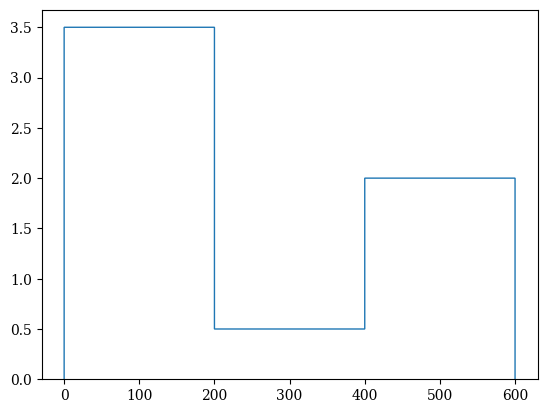

In [167]:
env = init_wrappers(SphericalTank(desired_state=np.array([0.5, 2.0, 3.5]), max_episode_len=600), observation_type='setpoint-error',randomise_setpoint=False)
plt.stairs(env.desired_trajectory)

Initial state was [0.75      0.3004372]


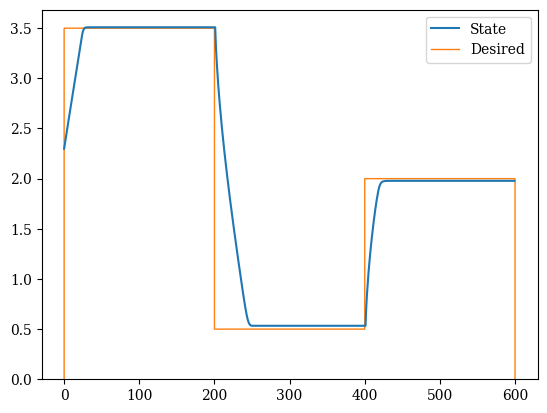

In [168]:
tank_agent = SAC.load('models\\SphericalTank\\setpoint-error\\randomised\\Desired3.6\\sac.zip')
tank_env = DelayAction(env, delay = 0)

states, actions, rewards, avg, desired = test_agent(tank_agent, tank_env, deterministic=True, state_error=True)
start = 0
stop = 600
plt.plot((np.array(states))[start:stop])
# plt.plot((np.array(desired))[start:stop])
plt.stairs(np.array(tank_env.unwrapped.desired_trajectory)[start:stop])
plt.legend(['State', 'Desired'])
# plt.plot(np.array(states)[:,1])


In [76]:
tank_env.unwrapped.initial_state

NameError: name 'tank_env' is not defined

## Safe agent

In [2]:
core_env = SphericalTank(desired_state=np.array([2.5]), max_episode_len=150, seed = 42)
core_env.reset()
# core_env.initial_state
# core_env = init_wrappers(core_env, observation_type='setpoint-error', randomise_setpoint=True)


safe_agent, env = train_default_augmented_sac(core_env = core_env, 
                                              agent_type='wcsac',
                                              desired_state=2.5,
                                              seed = 42,
                                              observation_type='setpoint-error',
                                              randomise_setpoint=False, 
                                              random_delay=True,
                                              n_episodes=200)

NameError: name 'SphericalTank' is not defined

In [183]:
core_env = init_wrappers(SphericalTank(desired_state=np.array([2.5]), max_episode_len=100, seed = 42), observation_type='setpoint-error', randomise_setpoint= True)
# core_env = ObserveSetpointError(SphericalTank(desired_state=np.array([2.5]), max_episode_len=100, seed = 42))
state, info = core_env.reset()
start = np.array([0.6, 0.1])
pred_state = predict_state(core_env, start, actions_queue=[np.array([0.0]), np.array([1.0])], delay=1)
print(f"Pred state {pred_state} from {start}")

Wrapping in random setpoint
Wrapping in observe setpoint error
Env model state [2.8] and cur_state [0.6 0.1]
Predicted state [0.6        0.08729472] with action [1.]
Pred state [0.6        0.08729472] from [0.6 0.1]


Wrapping in observe setpoint error
Desired [0.7], state [2.]


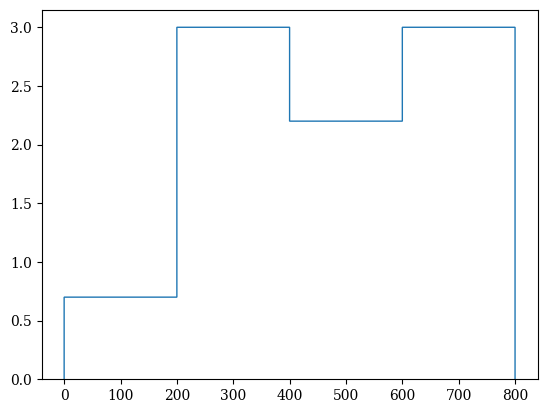

In [274]:
core_env = SphericalTank(desired_state=np.array([0.7, 3.0, 2.2]), start_state=np.array([2.0]), max_episode_len=800, seed = 58)
core_env = init_wrappers(core_env, observation_type='setpoint-error', randomise_setpoint=False)


env = DelayAction(core_env, delay = 10, random_delay=False, max_delay=global_config.MAX_DELAY)
env = AugmentState(env, known_delay=global_config.MAX_DELAY)
env.reset()
print(f"Desired {env.desired_state}, state {env.unwrapped.state}")
plt.stairs(env.desired_trajectory)

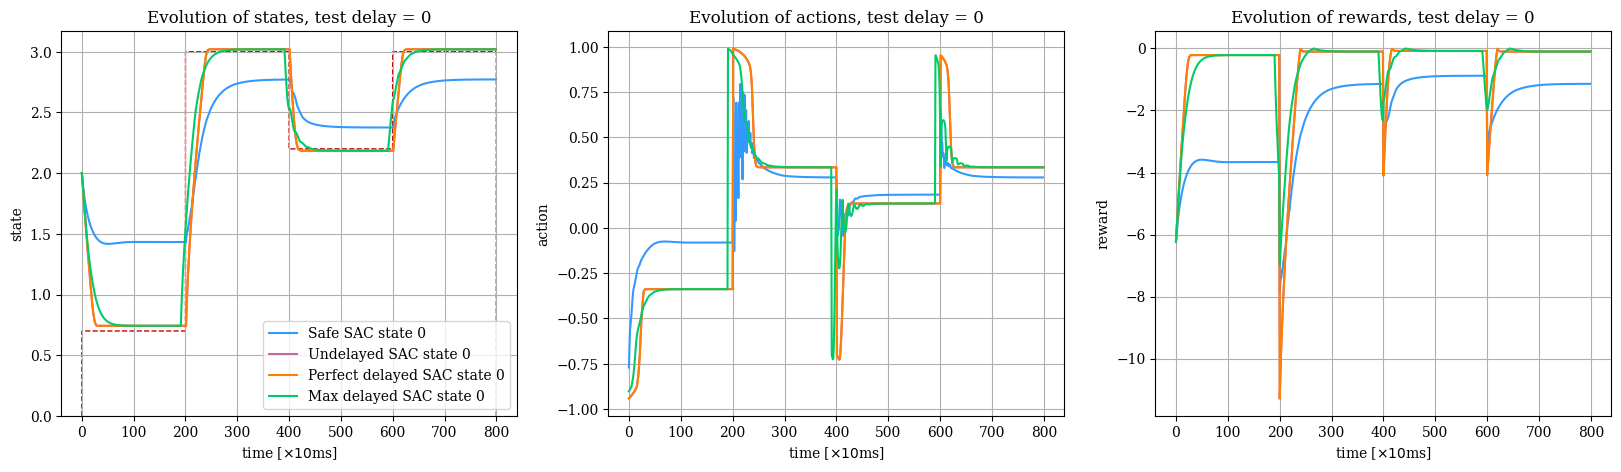

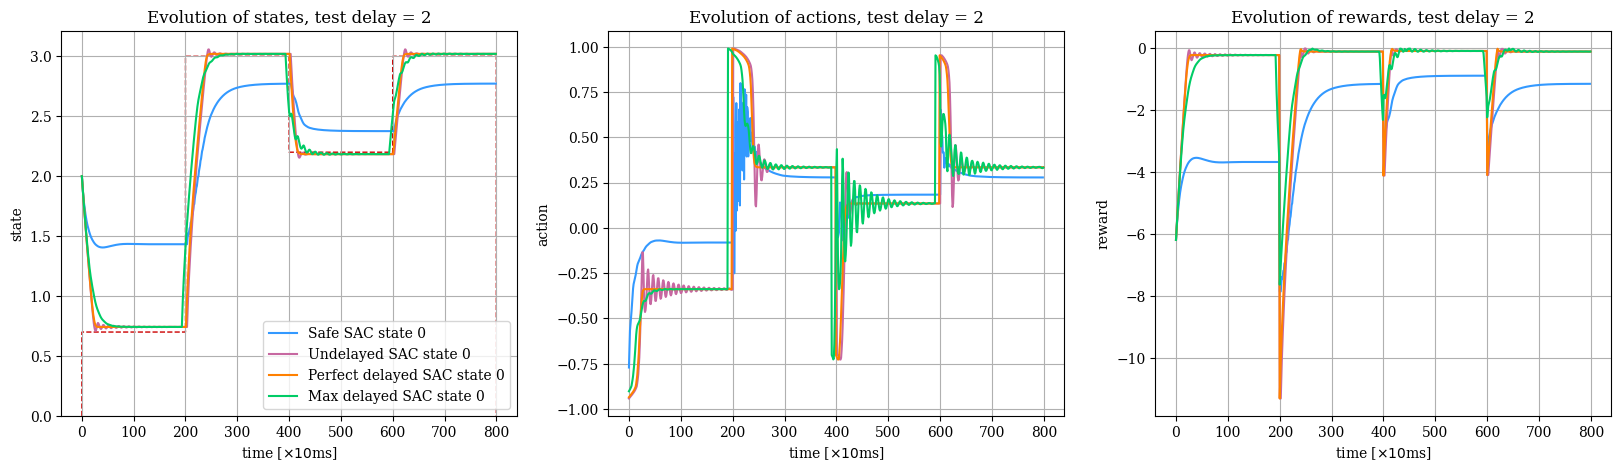

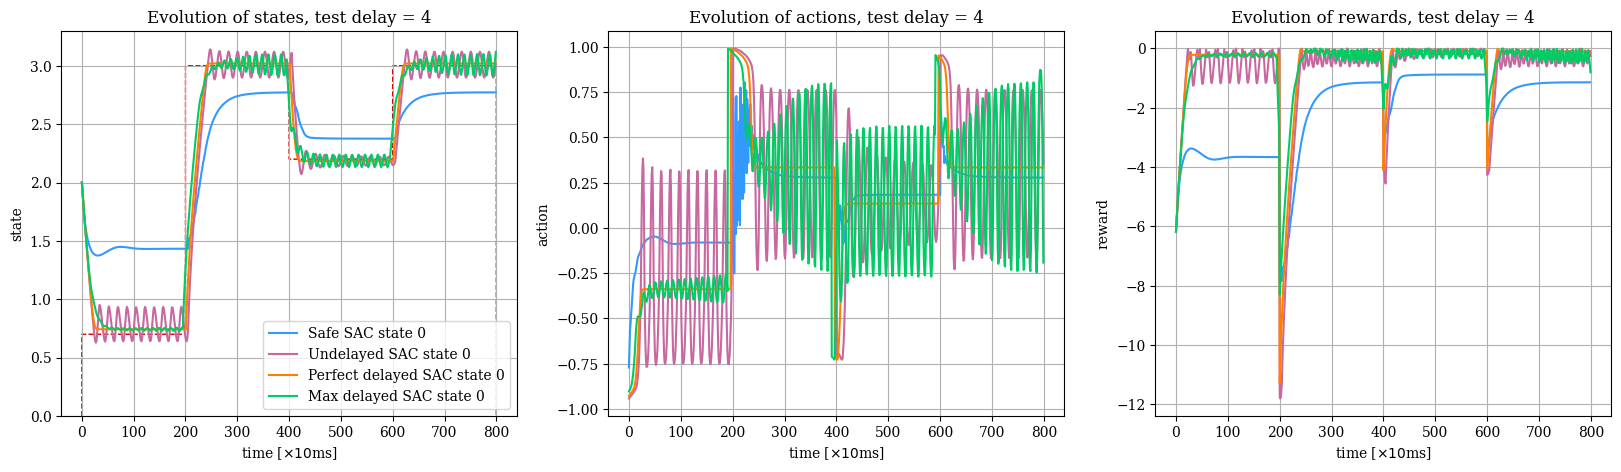

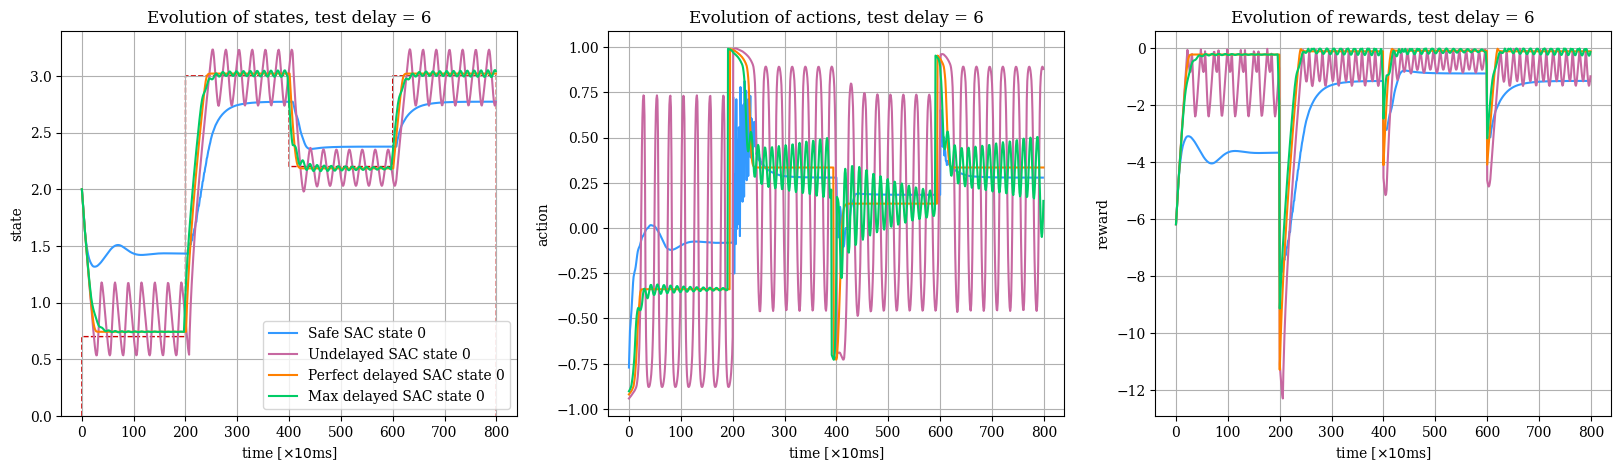

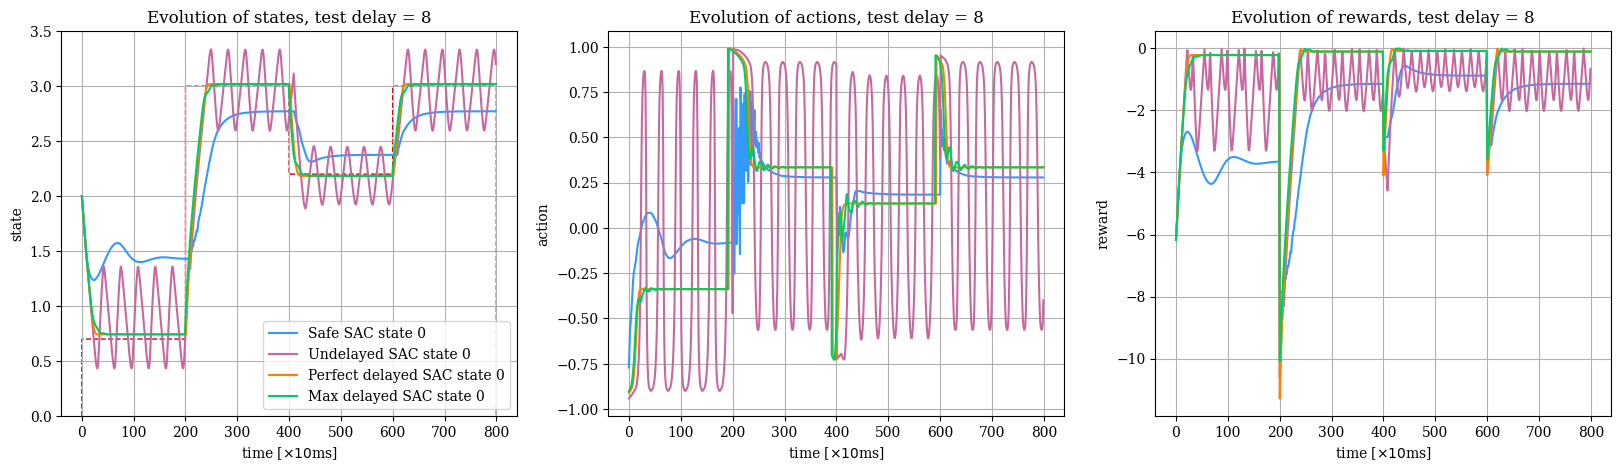

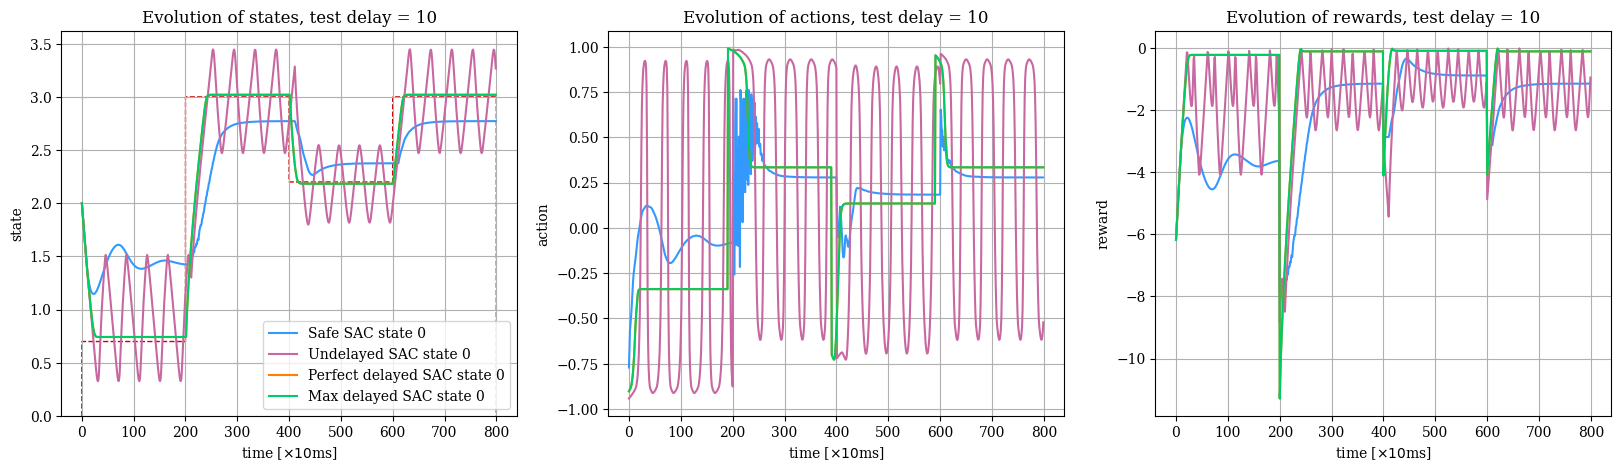

In [276]:
tank_agent = SAC.load('models\\SphericalTank\\setpoint-error\\randomised\\Desired3.6\\sac.zip')

results = test_different_delayed_agents(tank_agent,core_env, deterministic=True, augmented_agent=safe_agent )

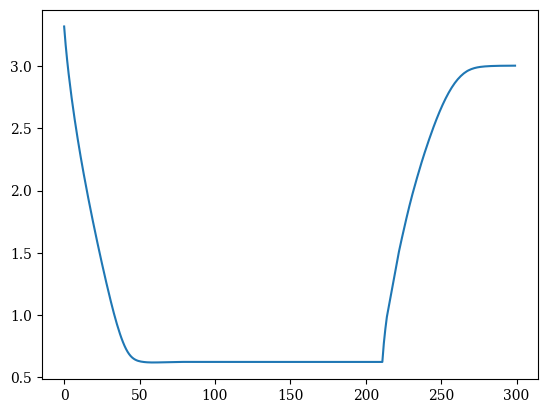

In [73]:
states, actions, rewards, avg, executed = test_augmented_agent(safe_agent, env, deterministic=True, state_error=True)
plt.plot(states)

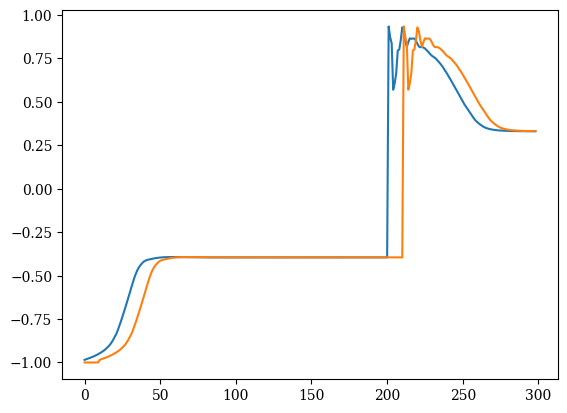

In [74]:
plt.plot(actions)
plt.plot(executed)